In [ ]:
from keras.layers import Input, Lambda, Dense
from keras.models import Model
from keras import backend as K
#from keras import objectives
from keras.datasets import mnist
import numpy as np

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype( 'float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape( (len(x_test),  np.prod(x_test.shape[1:])))

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
epochs       = 18       # número de epocas
batch_size   = 1  # tamaño del lote
original_dim = x_train.shape[1]    # 784 tamaño de las imágenes MNIST
intermediate_dim = 256  # dimensión intermedia
latent_dim   = 2        # número de parámetros del espacio latente


In [ ]:
x_train.shape

(60000, 784)

In [ ]:
def sample_z(args):
    z_mu, z_log_sigma2 = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mu + K.exp(z_log_sigma2 / 2) * epsilon

In [ ]:
# capa de entrada (datos) al decodificador
encoderIn = Input(shape=(original_dim,),
                  name="input")
# capa intermendia
encoder_H1 = Dense(units=intermediate_dim,
                   activation='relu',
                   name="encoding")(encoderIn)
# media y log-varianza del espacio latente
z_mu         = Dense(units=latent_dim,
                   name="mean")(encoder_H1)
z_log_sigma2 = Dense(units=latent_dim,
                   name="log-variance")(encoder_H1)
# muestreo de z con el truco de la reparametrizacion
z = Lambda(sample_z, output_shape=(latent_dim,))([z_mu, z_log_sigma2])

# Modelo del "encoder" las salidas son: media, log-varianza y muestra
encoder = Model(inputs=encoderIn,
                outputs=[z_mu, z_log_sigma2, z],
                name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 encoding (Dense)            (None, 256)                  200960    ['input[0][0]']               
                                                                                                  
 mean (Dense)                (None, 2)                    514       ['encoding[0][0]']            
                                                                                                  
 log-variance (Dense)        (None, 2)                    514       ['encoding[0][0]']            
                                                                                            

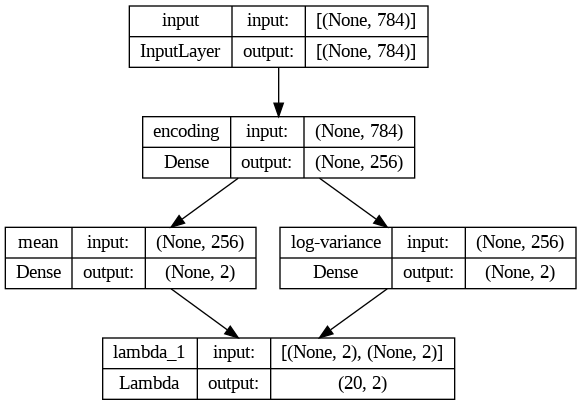

In [ ]:
from keras.utils import plot_model
plot_model(encoder, to_file='model_encoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
# capa de entrada (datos) al decodificador
decoderIn  = Input(shape=(latent_dim,),
                   name="decoder_input")
# capa intermedia
decoder_H1 = Dense(intermediate_dim,
                   activation='relu',
                   name="decoder_h")(decoderIn)
# capa de salida con dimensiones igual a las orginales
decoderOut = Dense(original_dim,
                   activation='sigmoid',
                   name="flat_decoded")(decoder_H1)
# definición del modelo del decodificador
decoder    = Model(inputs=decoderIn,
                   outputs=decoderOut,
                   name="decoder")

decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202256 (790.06 KB)
Trainable params: 202256 (790.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


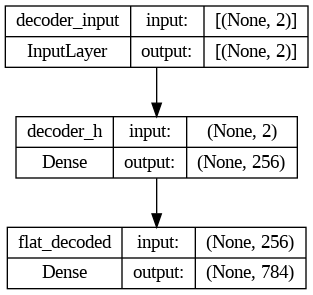

In [ ]:
plot_model(decoder, to_file='model_decoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
#VAE: encoder+decoder
vaeOut = decoder(encoder(encoderIn)[2])
# construimos el  modelo
vae = Model(inputs=encoderIn, outputs=vaeOut)
vae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404244 (1.54 MB)
Trainable params: 404244 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


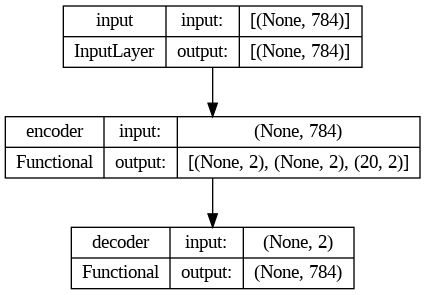

In [ ]:
plot_model(vae, to_file='model_vae.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Funcio de perdida ELBO
def ELBO(x, x_decoded_mean):
    logP = original_dim*K.binary_crossentropy(K.flatten(x), K.flatten(x_decoded_mean))
  #D(Q(z|x)||P(z))
    Dk1 = 0.5 * K.sum(K.exp(z_log_sigma2)+K.square(z_mu)-1. - z_log_sigma2, axis=-1)
    logP=K.mean(logP)
    return K.mean(logP+Dk1)

vae.compile(optimizer='rmsprop', loss=ELBO, metrics=['accuracy'])

In [ ]:
#Ajuste del Modelo
print("Training Start")
history=vae.fit(x_train[0:3], x_train[0:3],
        shuffle    = True,
        epochs     = 3,
        batch_size = batch_size,
        validation_data=(x_test, x_test),
        verbose=True)
print("Training End")

Training Start
Train on 3 samples, validate on 10000 samples
Epoch 1/3
1/3 [=========>....................] - ETA: 0s - loss: 89.7125 - accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3/3 [==============================] - 11s 5s/sample - loss: 178.6025 - accuracy: 0.0000e+00 - val_loss: 322.0317 - val_accuracy: 0.0015
Epoch 2/3
3/3 [==============================] - 11s 5s/sample - loss: 164.1201 - accuracy: 0.0000e+00 - val_loss: 337.0526 - val_accuracy: 0.0014
Epoch 3/3
3/3 [==============================] - 11s 6s/sample - loss: 160.6210 - accuracy: 0.0000e+00 - val_loss: 340.9522 - val_accuracy: 0.0013
Training End


In [ ]:
print(len(vae.get_weights()))


10


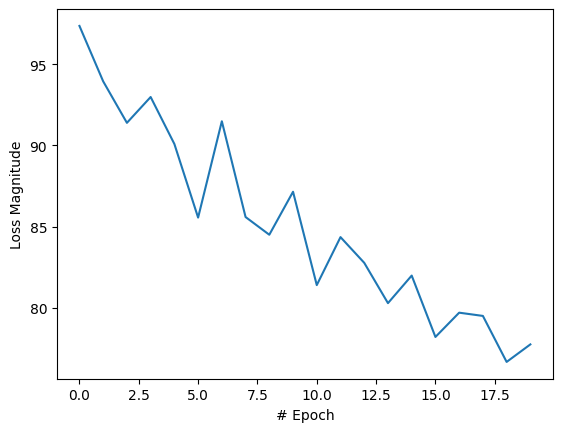

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("# Epoch")
plt.ylabel("Loss Magnitude")
plt.plot(history.history["loss"])

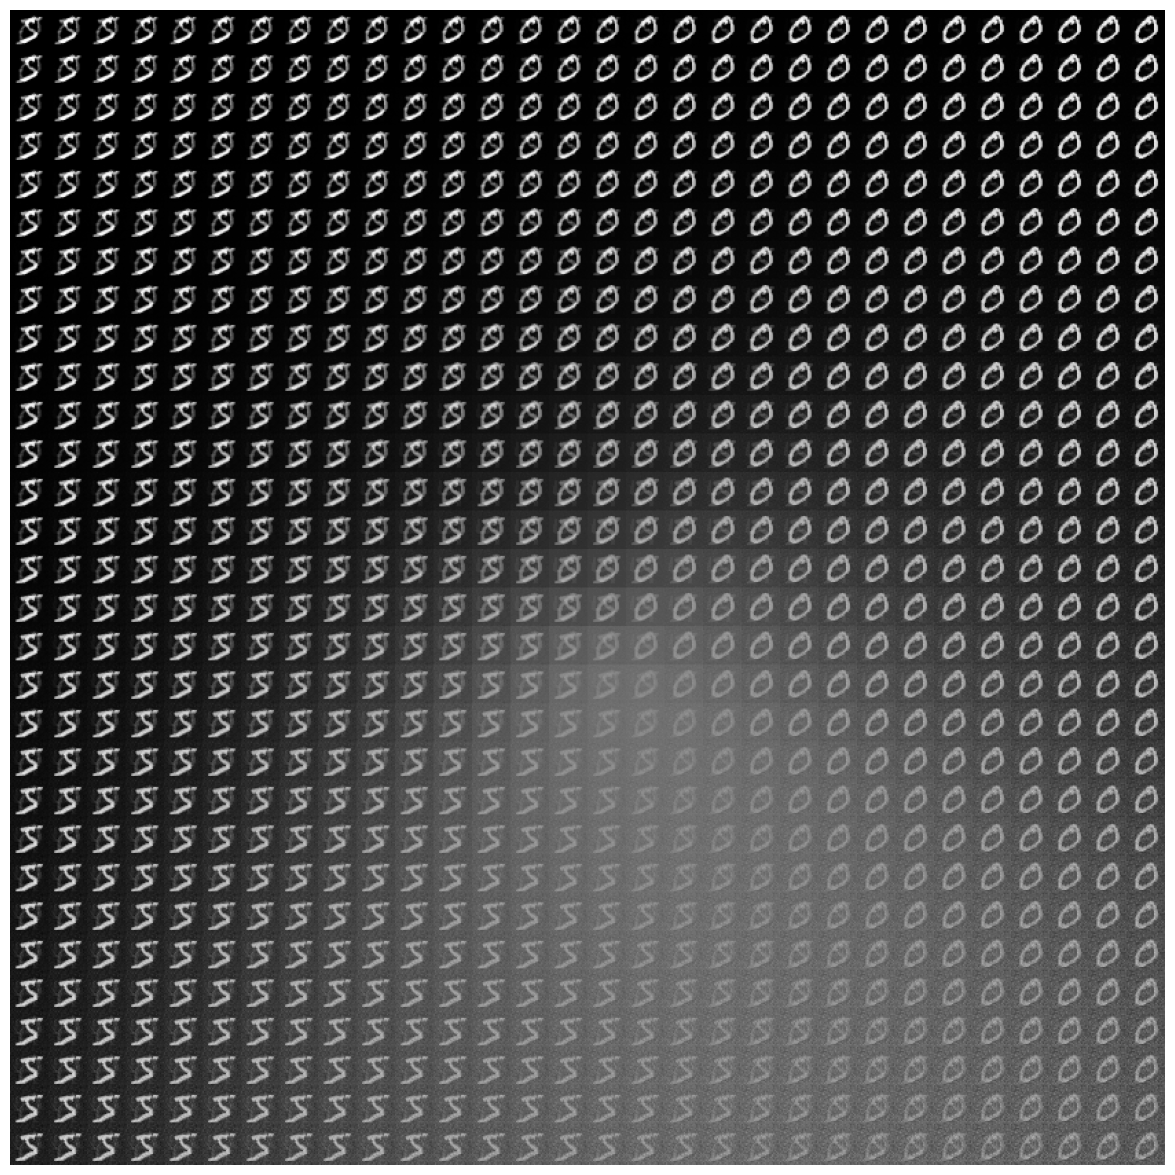

In [ ]:
numImgs = 30
newrows,newcols=28,28
lo, hi  = -3.,3.

z1 = np.linspace(lo, hi, numImgs)
z2 = np.linspace(lo, hi, numImgs)

import matplotlib.pyplot as plt

plt.figure(figsize=(15,15*newcols/newrows))
canvas=np.zeros((newrows*numImgs,newcols*numImgs))
for i in range(numImgs):
    for j in range(numImgs):
        z=np.array([z1[i], z2[j] ])
        z=np.expand_dims(z, axis=0)
        Im=decoder.predict(z)
        canvas[newrows*i:newrows*(i+1), newcols*j:newcols*(j+1)] = Im.reshape((newrows,newcols))

plt.imshow(canvas, 'gray')
plt.axis('off')
plt.show()

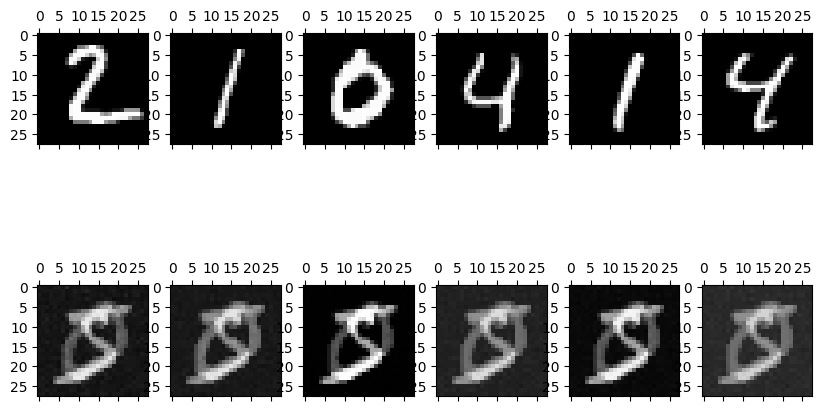

In [ ]:
fig, ax = plt.subplots(2,6, figsize = (10, 6))

for i in range(6): #Probamos con 3 imagenes del congunto de test
    number = x_test[i+1][None,:]
    in_number=np.repeat(number, 20, axis=0)
    out_number = vae.predict(in_number)
    out_number=out_number.reshape((20,784))[19]
    ax[0,i].matshow(number.reshape((28,28)),  cmap='gray', clim=(0,1))
    ax[1,i].matshow(out_number.reshape((28,28)), cmap='gray', clim=(0,1))
pass

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


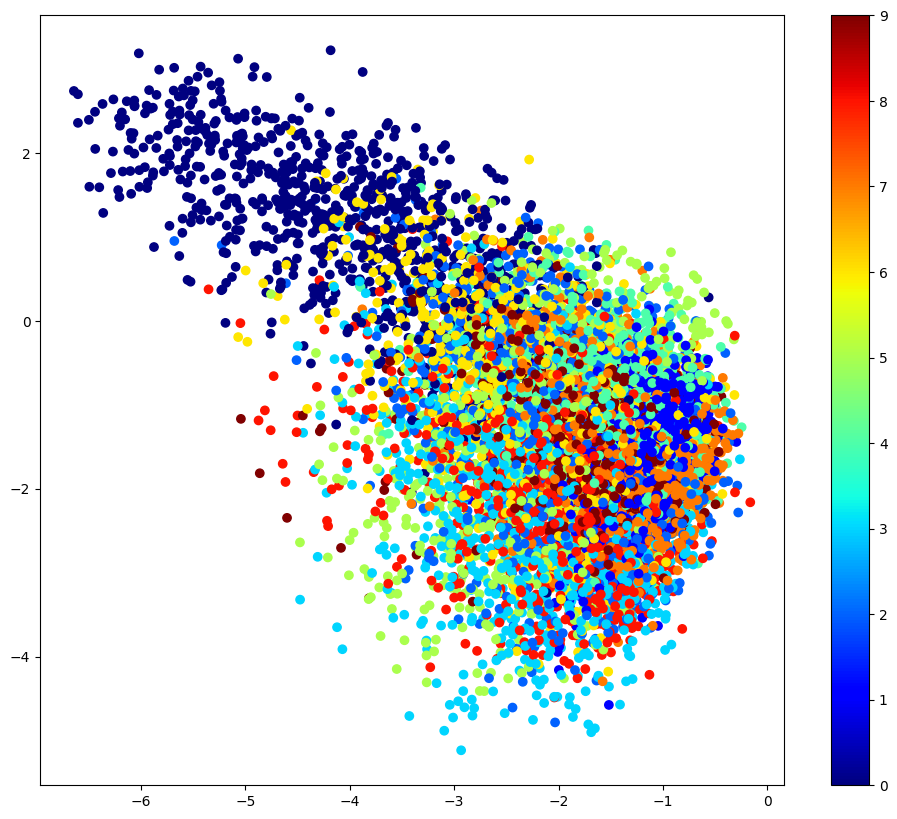

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(12, 10))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

[[0.48892763 0.54858977 0.5502793  0.5236619  0.56694216 0.52674365
  0.5137602  0.46637934 0.4573389  0.46112683 0.53913975 0.48081478
  0.52450675 0.5512915  0.50441194 0.50268126 0.51979536 0.53916764
  0.4272802  0.42518276 0.44081855 0.51082134 0.5011978  0.5522457
  0.44510663 0.502881   0.4811582  0.5458175 ]
 [0.4991349  0.49389324 0.51190084 0.4304467  0.5673886  0.46196872
  0.4724786  0.47752473 0.4917916  0.4911802  0.60368294 0.48928654
  0.52560544 0.4636862  0.55856663 0.52287287 0.5542455  0.56263316
  0.48104265 0.4387036  0.53011805 0.51873124 0.5032406  0.5149083
  0.5438271  0.48363018 0.58746135 0.4577144 ]
 [0.4921695  0.42676225 0.4955909  0.53072304 0.49020985 0.51098704
  0.5009996  0.46989197 0.5001304  0.5210881  0.5313689  0.5259663
  0.56502867 0.45125827 0.570969   0.4507889  0.5075319  0.48657757
  0.50044584 0.535441   0.4743695  0.5297285  0.52287436 0.42130724
  0.4444397  0.550659   0.5436677  0.47490913]
 [0.4524184  0.50956964 0.4697996  0.4708239  

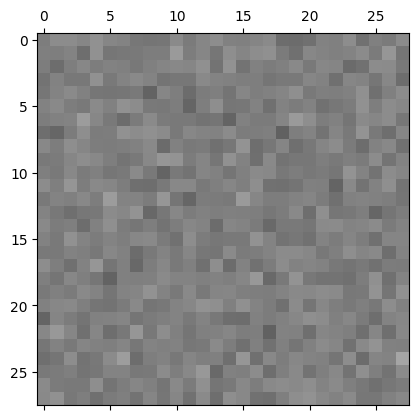

In [ ]:
number = x_test[1][None,:]
in_number=np.repeat(number, 20, axis=0)
out_number = vae.predict(in_number)
out_number=out_number.reshape((20,784))[19]
print(out_number.reshape((28,28)))
import matplotlib.pyplot as plt
plt.matshow(out_number.reshape((28,28)), cmap='gray', clim=(0,1))
pass

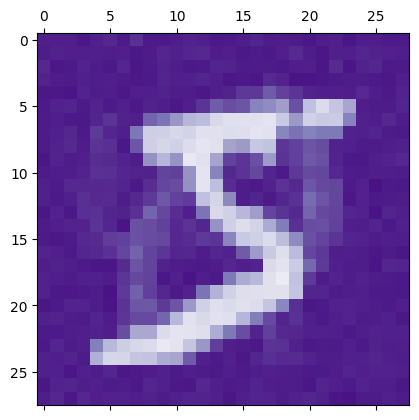

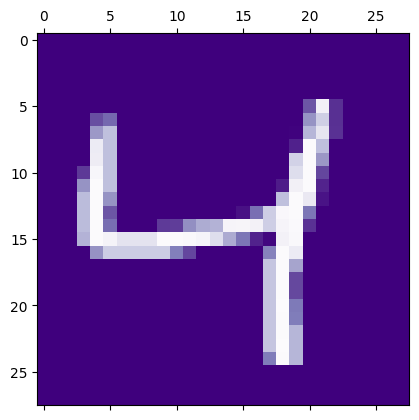

In [ ]:
img=x_train[2][None,:]
out=vae.predict(img)

plt.matshow(out.reshape((28,28)), cmap='Purples_r', clim=(0,1))
plt.matshow(img.reshape((28,28)), cmap='Purples_r', clim=(0,1))
pass